# GrIS melt causality

Author: Ziqi Yin

Last modified: 2025 Sep 26

Description: Causal inference of Greenland Ice Sheet summer surface melt
- Method: PCMCI+
- Period: 1940-1969
- Frequency: monthly
- Region: ablation zone
- Variables: SWn, LWn, SH, LH
- Source:

In [1]:
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
from matplotlib.gridspec import GridSpec

import sys
home_dir = '/glade/work/ziqiyin/'
sys.path.insert(0, home_dir)
from copy import deepcopy

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore')

import tigramite
import tigramite.data_processing as pp
import tigramite.plotting as tp

from tigramite.models import LinearMediation, Models
from tigramite.causal_effects import CausalEffects

from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.robust_parcorr import RobustParCorr
from tigramite.independence_tests.gpdc import GPDC

import tifffile

import cartopy
import cartopy.crs as ccrs
crs_np = ccrs.NorthPolarStereo(central_longitude=0)
crs_ll = ccrs.PlateCarree()

# https://github.com/hhuangwx/cmaps
import cmaps

import geopandas as gp
import regionmask

# For regridding
import os
import ESMF

import datetime
import pandas as pd

ERROR 1: PROJ: proj_create_from_database: Open of /glade/work/ziqiyin/conda-envs/my-npl-202306a/share/proj failed


In [2]:
# Function to remove seasonal mean and divide by seasonal standard deviation
def anomalize(dataseries, divide_by_std=True, reference_bounds=None, cycle_length=12, return_cycle=False):
    if reference_bounds is None:
        reference_bounds = (0, len(dataseries))

    anomaly = np.copy(dataseries)
    for t in range(cycle_length):
        if return_cycle:
            anomaly[t::cycle_length] = dataseries[t+reference_bounds[0]:reference_bounds[1]:cycle_length].mean(axis=0)
        else:
            anomaly[t::cycle_length] -= dataseries[t+reference_bounds[0]:reference_bounds[1]:cycle_length].mean(axis=0)
            if divide_by_std:
                anomaly[t::cycle_length] /= dataseries[t+reference_bounds[0]:reference_bounds[1]:cycle_length].std(axis=0)
    return anomaly

In [3]:
# Set Polar Sterographic Projection definition
polar_stereographic = ccrs.Stereographic(
    central_latitude=90.0,
    central_longitude=-45.0,
    false_easting=0.0,
    false_northing=0.0,
    true_scale_latitude=70.0,
    globe=ccrs.Globe('WGS84')
)

## Load data

### RACMO melt

In [4]:
RACMO_melt_monthly_sel = xr.open_dataset(home_dir+'data/RACMO/RACMO2.3p2_FGRN055/1940_2022/snowmelt.1940-2022.BN_RACMO2.3p2_ERA5_3h_1940_FGRN055.MM.nc')['snowmelt'][:,0,:,:].sel(time=slice('1940-01-01','1969-12-31')) #[mm/month]
RACMO_smb_monthly_sel = xr.open_dataset(home_dir+'data/RACMO/RACMO2.3p2_FGRN055/1940_2022/smb.1940-2022.BN_RACMO2.3p2_ERA5_3h_1940_FGRN055.MM.nc')['smb'][:,0,:,:].sel(time=slice('1940-01-01','1969-12-31')) #[mm/month]
racmo_lon = xr.open_dataset(home_dir+'data/RACMO/RACMO2.3p2_FGRN055/1940_2022/snowmelt.1940-2022.BN_RACMO2.3p2_ERA5_3h_1940_FGRN055.MM.nc')['lon'].values #[-180, 180]
racmo_lat = xr.open_dataset(home_dir+'data/RACMO/RACMO2.3p2_FGRN055/1940_2022/snowmelt.1940-2022.BN_RACMO2.3p2_ERA5_3h_1940_FGRN055.MM.nc')['lat'].values

### SEB fluxes

In [5]:
# Monthly mean surface SEB fluxes
RACMO_SWd_monthly_sel = xr.open_dataset(home_dir+'data/RACMO/RACMO2.3p2_FGRN055/1940_2022/swsd.1940-2022.BN_RACMO2.3p2_ERA5_3h_1940_FGRN055.MM.nc')['swsd'][:,0,:,:].sel(time=slice('1940-01-01','1969-12-31')) #should be [W/m2]
RACMO_SWu_monthly_sel = xr.open_dataset(home_dir+'data/RACMO/RACMO2.3p2_FGRN055/1940_2022/swsu.1940-2022.BN_RACMO2.3p2_ERA5_3h_1940_FGRN055.MM.nc')['swsu'][:,0,:,:].sel(time=slice('1940-01-01','1969-12-31'))
RACMO_LWd_monthly_sel = xr.open_dataset(home_dir+'data/RACMO/RACMO2.3p2_FGRN055/1940_2022/lwsd.1940-2022.BN_RACMO2.3p2_ERA5_3h_1940_FGRN055.MM.nc')['lwsd'][:,0,:,:].sel(time=slice('1940-01-01','1969-12-31'))
RACMO_LWu_monthly_sel = xr.open_dataset(home_dir+'data/RACMO/RACMO2.3p2_FGRN055/1940_2022/lwsu.1940-2022.BN_RACMO2.3p2_ERA5_3h_1940_FGRN055.MM.nc')['lwsu'][:,0,:,:].sel(time=slice('1940-01-01','1969-12-31'))
RACMO_SH_monthly_sel = xr.open_dataset(home_dir+'data/RACMO/RACMO2.3p2_FGRN055/1940_2022/senf.1940-2022.BN_RACMO2.3p2_ERA5_3h_1940_FGRN055.MM.nc')['senf'][:,0,:,:].sel(time=slice('1940-01-01','1969-12-31'))
RACMO_LH_monthly_sel = xr.open_dataset(home_dir+'data/RACMO/RACMO2.3p2_FGRN055/1940_2022/latf.1940-2022.BN_RACMO2.3p2_ERA5_3h_1940_FGRN055.MM.nc')['latf'][:,0,:,:].sel(time=slice('1940-01-01','1969-12-31'))
RACMO_SWn_monthly_sel = RACMO_SWd_monthly_sel + RACMO_SWu_monthly_sel
RACMO_LWn_monthly_sel = RACMO_LWd_monthly_sel + RACMO_LWu_monthly_sel

### Area

In [6]:
racmo_area = xr.open_dataset(home_dir+'data/RACMO/RACMO2.3p2_FGRN055/FGRN055_Masks.nc')['Area'] * 1e6 # Grid-cell area [m2]

### Ablation zone from RACMO

In [7]:
year = RACMO_smb_monthly_sel.time.dt.year
RACMO_smb_yearly_sel = RACMO_smb_monthly_sel.groupby(year).sum() #[mm/yr]
RACMO_smb_yearly_mean_sel = RACMO_smb_yearly_sel.mean(dim='year')

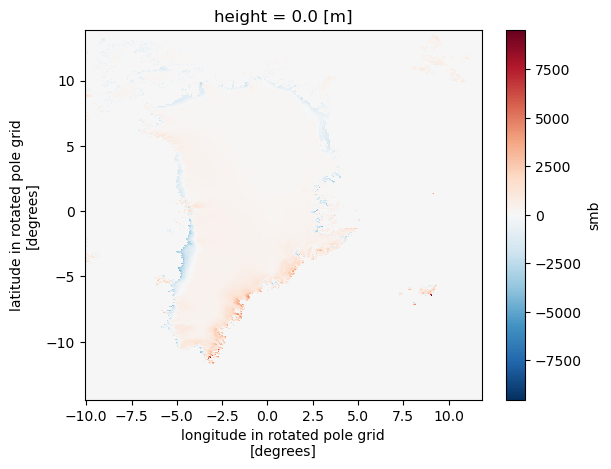

In [8]:
RACMO_smb_yearly_mean_sel.plot();

In [9]:
# Save the averaged SMB field as netcdf file
racmo_rlat = RACMO_smb_yearly_mean_sel.rlat.values
racmo_rlon = RACMO_smb_yearly_mean_sel.rlon.values
df = xr.DataArray(RACMO_smb_yearly_mean_sel.values, dims=['rlat','rlon'], coords=[('rlat', racmo_rlat),('rlon', racmo_rlon)], name='SMB', attrs=dict(longname='RACMO mean SMB averaged over 1940-1969', units='mm/yr'))
df.to_netcdf(home_dir+'2023-GrIS-melt-causality/data/RACMO/RACMO_smb_yearly_mean_1940_1969.nc')

In [10]:
# Select grid points that have <0 smb
fill_value = RACMO_smb_yearly_mean_sel[0,0].values
RACMO_ablation_mask_sel = xr.where(RACMO_smb_yearly_mean_sel == fill_value, np.NaN, RACMO_smb_yearly_mean_sel)
RACMO_ablation_mask_sel = xr.where(RACMO_ablation_mask_sel < 0, 1, 0)  #

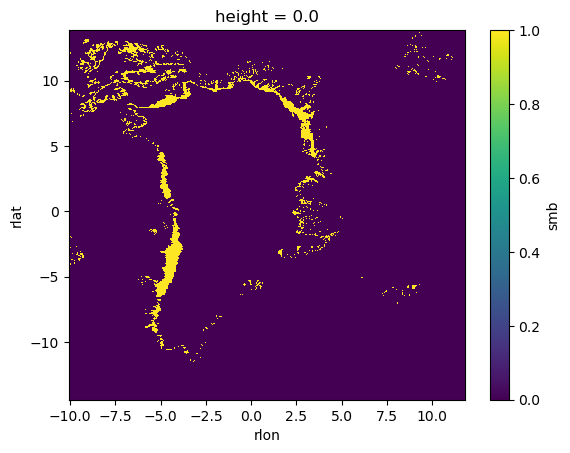

In [11]:
RACMO_ablation_mask_sel.plot();

### Mask

#### RACMO grid

In [12]:
racmo_landmask = xr.open_dataset(home_dir+'data/RACMO/RACMO2.3p2_FGRN055/FGRN055_Masks.nc')['LSM_GR'] #Land sea mask (land:1, sea:0)
#racmo_icemask = xr.open_dataset(home_dir+'data/RACMO/RACMO2.3p2_FGRN055/FGRN055_Masks.nc')['Icemask_GR'] #Ice mask(ice sheet + ice caps)
racmo_icemask = xr.open_dataset(home_dir+'data/RACMO/RACMO2.3p2_FGRN055/FGRN055_Masks.nc')['Promicemask'] #Ice mask(only ice sheet)
racmo_icemask = xr.where(racmo_icemask==4, 1, 0)
racmo_GrIS_mask = racmo_landmask * racmo_icemask # [only 0 or 1]

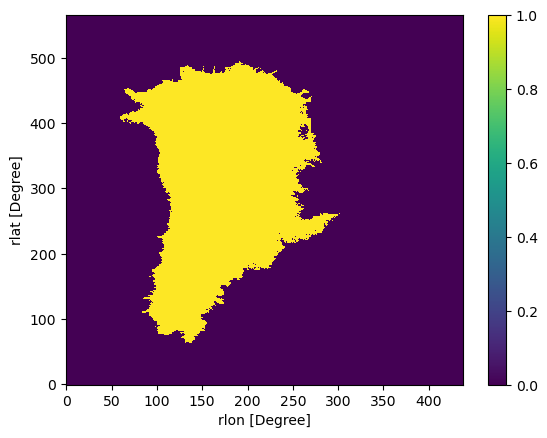

In [13]:
racmo_GrIS_mask.plot();

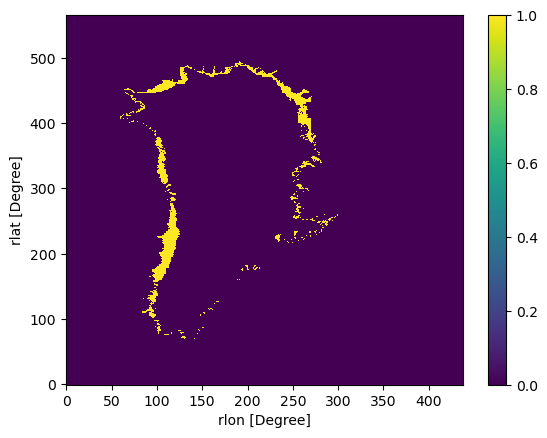

In [14]:
racmo_GrIS_ablation_mask = racmo_GrIS_mask * RACMO_ablation_mask_sel.values
racmo_GrIS_ablation_mask.plot();

In [15]:
# Save ablation mask as netcdf file
df = xr.DataArray(racmo_GrIS_ablation_mask.where(racmo_GrIS_ablation_mask>0).values, dims=['rlat','rlon'], coords=[('rlat', racmo_rlat),('rlon', racmo_rlon)], name='SMB', attrs=dict(longname='RACMO mean ablation mask over 1940-1969', units=''))
df.to_netcdf(home_dir+'2023-GrIS-melt-causality/data/RACMO/RACMO_ablation_mask_yearly_mean_1940_1969.nc')

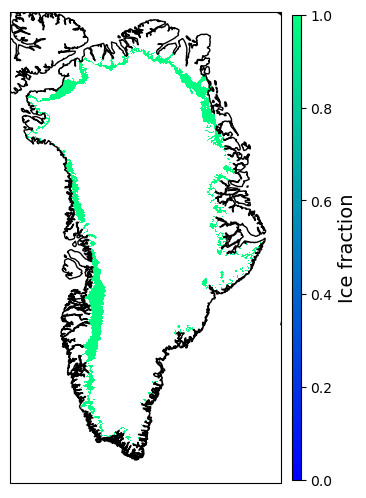

In [14]:
fig = plt.figure(figsize = (3.5,6.2))
gs=GridSpec(1,1)
plt.rcParams['axes.titlepad'] =14

#---------------------------------------------1----------------------------------------------------
ax1 = plt.subplot(gs[0], projection=polar_stereographic)
ax1.set_extent([-56.4, -29.6, 58, 84])
ax1.coastlines(resolution='10m', zorder=7)

im1 = ax1.pcolormesh(racmo_lon, racmo_lat, racmo_GrIS_ablation_mask.where(racmo_GrIS_ablation_mask>0), cmap='winter', transform=ccrs.PlateCarree(), vmin=0, vmax=1)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# colorbar
cbar_ax1 = fig.add_axes([0.93, 0.121, 0.025, 0.75])
cb1 = fig.colorbar(im1, cax=cbar_ax1, orientation='vertical')
cb1.set_label(label='Ice fraction', size=14)
cb1.ax.tick_params(labelsize=10)


plt.subplots_adjust(wspace=0.2)
plt.savefig(home_dir+'2023-GrIS-melt-causality/plot/RACMO/Ice_fraction_ablation_RACMO_historical_1940_1969.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)


## Calculate

In [16]:
# Melt
days_in_month = RACMO_melt_monthly_sel.time.dt.days_in_month # [day]
RACMO_GrIS_melt_monthly_sel = (RACMO_melt_monthly_sel * racmo_GrIS_ablation_mask.values * racmo_area.values).sum(dim=['rlon','rlat']) / 1e3 # [m3/month]
RACMO_GrIS_melt_monthly_sel = RACMO_GrIS_melt_monthly_sel * 1e3 / days_in_month.values # [kg/day]

In [17]:
# SEB
RACMO_GrIS_SWn_monthly_sel = (RACMO_SWn_monthly_sel * racmo_GrIS_ablation_mask.values * racmo_area.values).sum(dim=['rlon','rlat']) / (racmo_GrIS_ablation_mask * racmo_area.values).sum(dim=['rlon','rlat'])
RACMO_GrIS_LWn_monthly_sel = (RACMO_LWn_monthly_sel * racmo_GrIS_ablation_mask.values * racmo_area.values).sum(dim=['rlon','rlat']) / (racmo_GrIS_ablation_mask * racmo_area.values).sum(dim=['rlon','rlat'])
RACMO_GrIS_SH_monthly_sel = (RACMO_SH_monthly_sel * racmo_GrIS_ablation_mask.values * racmo_area.values).sum(dim=['rlon','rlat']) / (racmo_GrIS_ablation_mask * racmo_area.values).sum(dim=['rlon','rlat'])
RACMO_GrIS_LH_monthly_sel = (RACMO_LH_monthly_sel * racmo_GrIS_ablation_mask.values * racmo_area.values).sum(dim=['rlon','rlat']) / (racmo_GrIS_ablation_mask * racmo_area.values).sum(dim=['rlon','rlat'])

## Data pre-processing

In [19]:
time = np.arange('1940-01', '1970-01', dtype='datetime64[M]')  # monthly time steps

# --- Create xarray Dataset ---
ds = xr.Dataset(
    {
        "Melt": (("time",), RACMO_GrIS_melt_monthly_sel.values/1e12),  # [Gt/day]
        "SWn": (("time",), RACMO_GrIS_SWn_monthly_sel.values),  # [W/m2]
        "LWn": (("time",), RACMO_GrIS_LWn_monthly_sel.values),
        "SH": (("time",), RACMO_GrIS_SH_monthly_sel.values),
        "LH": (("time",), RACMO_GrIS_LH_monthly_sel.values),
    },
    coords={"time": time},
)

# --- Save to NetCDF file ---
ds.to_netcdf("RACMO_GrIS_ablation_monthly_vars_1940_1969_mask_1940_1969.nc")

In [20]:
RACMO_GrIS_vars_monthly_1940_1969 = xr.open_dataset(home_dir+'2023-GrIS-melt-causality/RACMO/RACMO_GrIS_ablation_monthly_vars_1940_1969_mask_1940_1969.nc')
RACMO_GrIS_melt_monthly_1940_1969 = RACMO_GrIS_vars_monthly_1940_1969.Melt
RACMO_GrIS_SWn_monthly_1940_1969 = RACMO_GrIS_vars_monthly_1940_1969.SWn
RACMO_GrIS_LWn_monthly_1940_1969 = RACMO_GrIS_vars_monthly_1940_1969.LWn
RACMO_GrIS_SH_monthly_1940_1969 = RACMO_GrIS_vars_monthly_1940_1969.SH
RACMO_GrIS_LH_monthly_1940_1969 = RACMO_GrIS_vars_monthly_1940_1969.LH

In [21]:
# Stack arrays in sequence vertically (row wise)
data = np.vstack((
    RACMO_GrIS_melt_monthly_1940_1969.values,  # [Gt/day]
    RACMO_GrIS_SWn_monthly_1940_1969.values, # [W/m2]
    RACMO_GrIS_LWn_monthly_1940_1969.values,
    RACMO_GrIS_SH_monthly_1940_1969.values,
    RACMO_GrIS_LH_monthly_1940_1969.values
    )).T

T, N = data.shape

# Variable names used throughout
var_names = ['Melt', 'SWn', 'LWn', 'SH', 'LH']

The next question is about stationarity. A trend and seasonal cycle can introduce non-stationary dependencies that cannot be explained causally, that is, can act as confounders. Hence, as pre-processing steps, the trend and seasonal cycle are removed by first substracting both the trend (for example, caused by greenhouse gas forcing) and the seasonal cycle and then dividing by the seasonal variance. The length scale of the Gaussian kernel used for finding the long-term trend is assumed to be decadal ($15$ years). 

In [19]:
# Smooth-width set to 15 years
cycle_length = 12  # a year in monthly time resolution 
smooth_width = 15*cycle_length

if smooth_width is not None:
    smoothdata_here = pp.smooth(np.copy(data), smooth_width=smooth_width, kernel='gaussian',
                    residuals=False)
    data_here = pp.smooth(np.copy(data), smooth_width=smooth_width, kernel='gaussian',
                    residuals=True)
else:
    print("Not smoothed.")
    data_here = np.copy(data)

# Remove seasonal mean and divide by seasonal standard deviation
seasonal_cycle = anomalize(np.copy(data_here), cycle_length=cycle_length, return_cycle=True)
smoothdata_here += seasonal_cycle

Further, considering the regime behavior of the system as explained above, only the summer months June to August are considered. On a technical level, this selection of considered time periods is achieved by applying a so-called mask (also see [masking tutorial](https://github.com/jakobrunge/tigramite/blob/master/tutorials/dataset_challenges/tigramite_tutorial_missing_masking.ipynb) in tigramite).

More specifically, here the mask is such that samples for all the variables at time $t$ can only come from Jun-Aug, while samples for the times $t-1$ and $t-2$ can also come from outside this mask. This masking procedure results in a small sample size of $n=240$. 

In [20]:
# Construct mask to only select June to August
# (cycle_length is the length of the year in the bimonthly time series)
cycle_length = 12
mask = np.ones(data.shape, dtype='bool')
for i in np.arange(5,8).tolist():
    mask[i::cycle_length, :] = False

The figure below shows (in black) the raw data and overlaid (in red) the sum of 1) the low-frequency variability including the long-term trend, which is obtained by smoothing the time series using a Gaussian kernel with 15-year length scale, and 2) the seasonal cycle of the detrended residuals. Masked samples are in grey.

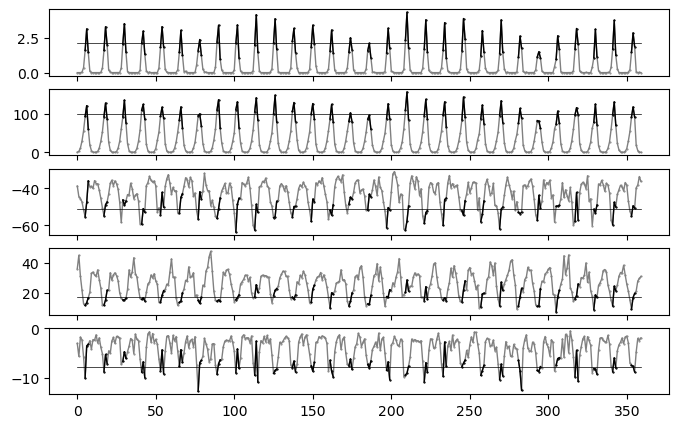

In [21]:
# Dataframe for raw data
raw_dataframe = pp.DataFrame(np.copy(data), mask=mask, var_names=var_names, datatime={0:np.arange(len(data))})
#raw_dataframe = pp.DataFrame(np.copy(data), var_names=var_names, datatime={0:np.arange(len(data))})

# Dataframe for smoothed data
smoothdataframe_here = pp.DataFrame(smoothdata_here, var_names=var_names,  datatime={0:np.arange(len(data))})

fig, axes = tp.plot_timeseries(
        raw_dataframe,
        figsize=(8, 5),
        grey_masked_samples='data',
        color='black',
        show_meanline=True,
        adjust_plot=False,
        )  

#tp.plot_timeseries(
#        smoothdataframe_here,
#        fig_axes = (fig, axes),
#        grey_masked_samples='data',
#        show_meanline=False,
#        color='red',
#        alpha=0.4,
#        adjust_plot=True,
#        tick_label_size=7,
#        label_fontsize=8,
#        time_label='Month',
#        var_units=['Gt/d', 'W/m2', 'W/m2', 'W/m2', 'W/m2'],
##         save_name="timeseries.pdf"
#        ); plt.show()

We now continue with the pre-processed data.

In [22]:
if smooth_width is not None:
    data_here = pp.smooth(data=np.copy(data), smooth_width=smooth_width, kernel='gaussian',
                    residuals=True)
else:
    data_here = np.copy(data)

data_here = anomalize(data_here, cycle_length=cycle_length)

# Initialize Tigramite dataframe with mask, missing_flag is not needed here
dataframe = pp.DataFrame(data_here, mask=mask, var_names=var_names, missing_flag=999.)
#dataframe = pp.DataFrame(data_here, var_names=var_names, missing_flag=999.)

#data_smooth = data_here

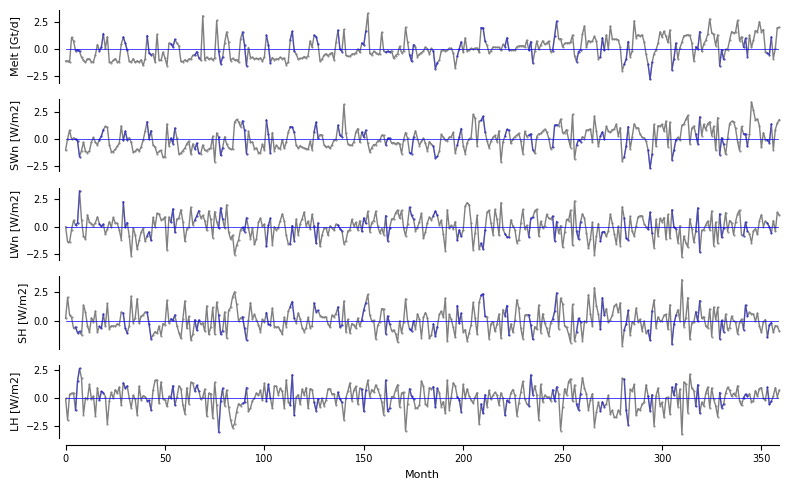

In [23]:
fig, axes = tp.plot_timeseries(
        dataframe,
        figsize=(8, 5),
        grey_masked_samples='data',
        show_meanline=True,
        color='blue',
        alpha=0.4,
        adjust_plot=True,
        tick_label_size=7,
        label_fontsize=8,
        time_label='Month',
        var_units=['Gt/d', 'W/m2', 'W/m2', 'W/m2', 'W/m2'],
#         save_name="timeseries.pdf"
        ); plt.show()

### Investigating data dependencies and lag functions

To investigate the type of dependencies, we use the ``plot_scatterplots`` and  ``plot_densityplots`` functions to see whether the dependencies are really linear. With the argument ``matrix_lags`` set to a ``(N, N)`` integer numpy array you can choose which lag to use for every pair of variables. Here it is left ``None`` implying lag zero.

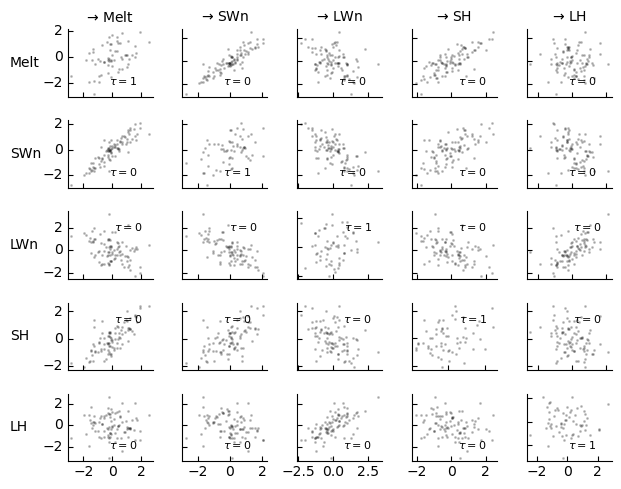

In [24]:
matrix_lags = None #np.argmax(np.abs(correlations), axis=2)
#matrix_lags = np.argmax(np.abs(correlations), axis=2)

# Standardize data to make it comparable
data_smooth_here = deepcopy(data_here)
mean, std = pp.weighted_avg_and_std(data_smooth_here, axis=0, weights=(mask==False))
data_smooth_here -= mean
data_smooth_here /= std

dataframe_here = pp.DataFrame(data_smooth_here, mask=mask, var_names=var_names)

tp.plot_scatterplots(dataframe=dataframe_here, add_scatterplot_args={'matrix_lags':matrix_lags}); plt.show()

(The diagonal panels show the lag-zero scatter plots of variables with itself here.)

Next, we investigate kernel density estimates of the joint and marginal (diagonal panels) densities.

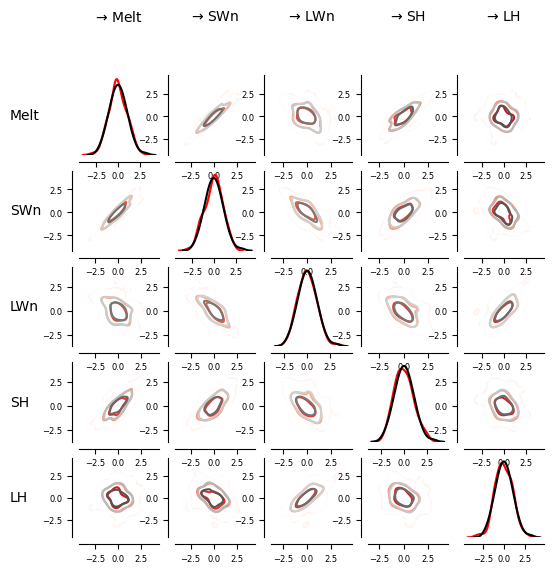

In [25]:
matrix = tp.setup_density_matrix(N=N, 
        var_names=dataframe_here.var_names, **{
        'figsize':(6, 6), 
        'tick_label_size':6,
        'label_space_left':0.18})

# Now transform data to normal marginals
data_normal = deepcopy(data_here)
data_normal = pp.trafo2normal(data_here, mask=mask)
dataframe_normal = pp.DataFrame(data_normal, mask=mask, var_names=var_names)

matrix.add_densityplot(dataframe=dataframe_here,
    matrix_lags=matrix_lags, label_color='red',
    snskdeplot_args = {'cmap':'Reds', 'alpha':1., 'levels':4})

matrix.add_densityplot(dataframe=dataframe_normal,
    matrix_lags=matrix_lags, label_color='black',
    snskdeplot_args = {'cmap':'Greys', 'alpha':1., 'levels':4})

The marginal densities (red) are slightly non-normal. By transforming the variables such that their marginals are normally distributed, the resulting joint densities are reasonably linear. Here there are only small differences, but these can nevertheless affect the conditional independence tests. Therefore, conditional independence tests in PCMCI+ should be undertaken with a robust partial correlation (``RobustParCorr``) here, which is a variant of partial correlation where the variables are first transformed to normally-distributed marginals. With ``significance='analytic'`` the null distribution is assumed to be Student's $t$. 

Next, it's a good idea to plot the lagged unconditional dependencies, e.g., the lagged correlations using the ``RobustParCorr`` class. This can help to identify which maximal time lag ``tau_max`` to choose in the causal algorithm.
 
To this end we initialize the ``PCMCI`` method with  ``dataframe``, and ``RobustParCorr`` as a ``cond_ind_test``. 

In [26]:
robustparcorr = RobustParCorr(significance='analytic', mask_type='y')
pcmci = PCMCI(
    dataframe=dataframe,
    cond_ind_test=robustparcorr,
    verbosity=1)

Before running PCMCIplus, it's a good idea to run and plot the function ``run_bivci``, which implements a bivariate, lagged conditional independence test (similar to bivariate Granger causality, but lag-specific). This can help to identify which maximal time lag ``tau_max`` to choose. Another option would be to plot ``get_lagged_dependencies``, but large autocorrelation will inflate lag peaks (see https://journals.ametsoc.org/doi/full/10.1175/JCLI-D-13-00159.1) and ``run_bivci`` at least conditions out some part of the autocorrelation.


##
## Estimating lagged dependencies 
##

Parameters:

independence test = robust_par_corr
tau_min = 0
tau_max = 20


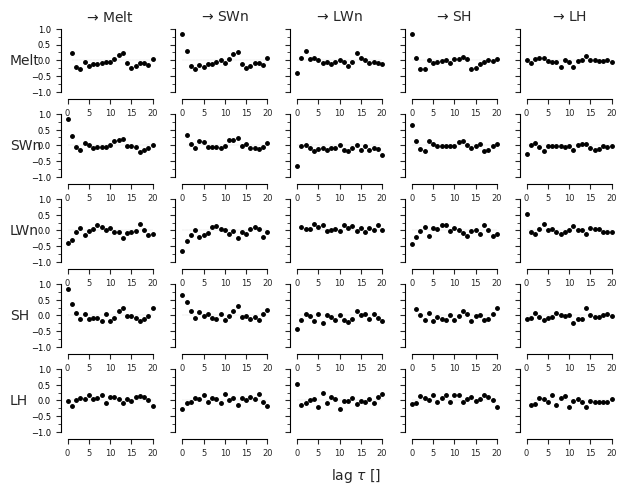

In [27]:
correlations = pcmci.get_lagged_dependencies(tau_max=20, val_only=True)['val_matrix']
#correlations = pcmci.run_bivci(tau_max=20, val_only=True)['val_matrix']
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, setup_args={'var_names':var_names, 
                                    'x_base':5, 'y_base':.5}); plt.show()

## PCMCI+ causal discovery

Here, since the dependencies in the lag function plot above decay beyond a maximum lag of around 8, we choose ``tau_max=8`` for PCMCI. The other main parameter is ``pc_alpha`` which sets the significance level in the condition-selection step. Here we let PCMCI choose the optimal value by setting it to ``pc_alpha=None``. Then PCMCI will optimize this parameter in the ParCorr case by the Akaike Information criterion among a reasonable default list of values (e.g., ``pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]``). The parameter ``alpha_level=0.01`` indicates that we threshold the resulting p-value matrix at this significance level to obtain the graph. 

In [27]:
pcmci.verbosity = 0
results = pcmci.run_pcmciplus(tau_min=0, tau_max=12, pc_alpha=0.1, contemp_collider_rule='conservative') #reset_lagged_links=True adds more links to piControl case, not 4xext
#results = pcmci.run_pcmciplus(tau_min=0, tau_max=15, pc_alpha=0.01)

In [28]:
#print("p-values")
#print (results['p_matrix'].round(3))
#print("MCI partial correlations")
#print (results['val_matrix'].round(2))

print("Graph")
print (results['graph'])
print("Adjacency MCI partial correlations")
print (results['val_matrix'].round(2))
print("Adjacency p-values")
print (results['p_matrix'].round(3))

Graph
[[['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
  ['-->' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
  ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
  ['o-o' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
  ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']]

 [['<--' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
  ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
  ['x-x' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
  ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
  ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']]

 [['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
  ['x-x' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
  ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
  ['<--' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
  ['o-o' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']]

 [['o-o' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
  ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
  ['-->' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
  ['' '' '' '' '' '' '' '

### False-discovery rate control

If we want to control for the $N^2 \tau_\max$ tests conducted here, we can further correct the p-values, e.g., by False Discovery Rate (FDR) control yielding the ``q_matrix``. The graph can then be updated with that adjusted ``p_matrix`` and a different ``alpha_level`` using ``get_graph_from_pmatrix()``.

In [28]:
#q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=15, fdr_method='fdr_bh')
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh', exclude_contemporaneous=False)
pcmci.print_significant_links(
        p_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)
graph = pcmci.get_graph_from_pmatrix(p_matrix=q_matrix, alpha_level=0.01, 
            tau_min=0, tau_max=15, link_assumptions=None)
results['graph'] = graph


## Significant links at alpha = 0.01:

    Variable Melt has 2 link(s):
        (SWn  0): pval = 0.00000 | val =  0.804
        (SH  0): pval = 0.00000 | val =  0.547

    Variable SWn has 2 link(s):
        (Melt  0): pval = 0.00000 | val =  0.804
        (LWn  0): pval = 0.00000 | val = -0.404

    Variable LWn has 3 link(s):
        (LH  0): pval = 0.00000 | val =  0.604
        (SWn  0): pval = 0.00000 | val = -0.404
        (SH -3): pval = 0.00981 | val = -0.250

    Variable SH has 1 link(s):
        (Melt  0): pval = 0.00000 | val =  0.547

    Variable LH has 1 link(s):
        (LWn  0): pval = 0.00000 | val =  0.604


### Further relevant methodological tutorials

The tutorial ``assumptions`` explains the underlying assumptions of causal discovery and how violations of these affect the methods.

Here we showcased ``run_pcmci`` which assumes no contemporaneous causal links. Have a look at ``run_pcmciplus`` in the corresponding tutorial ``pcmciplus`` for a method that can also detect (and account for confounding due to) contemporaneous causal links.

The tutorial ``latent-pcmci`` explains the class ``LPCMCI`` that can be used if you want to allow for hidden confounding in addition to contemporaneous links.

the tutorial ``tigramite_tutorial_jpcmciplus`` shows how to utilize multiple datasets to learn joint causal graphs and overcome some kinds of hidden confounding.

The tutorial ``conditional_independence_tests`` gives an overview of all conditional independence tests available in tigramite, including those for nonlinear and categorical variables.

The tutorial ``tigramite_tutorial_bootstrap_aggregation`` shows how bootstrap can be used for more robust causal graphs and confidence estimation of links.

The tutorial ``pcmci_fullci`` compares PCMCI with alternative estimators of vector-autoregressive models.

## Plotting

Tigramite offers several plotting options: The lag function matrix (as shown above), the time series graph, and the process graph which aggregates the information in the time series graph. Both take as arguments the ``graph`` array and optionally the ``val_matrix`` and further link attributes.

In the process graph, the node color denotes the auto-MCI value and the link colors the cross-MCI value. If links occur at multiple lags between two variables, the link color denotes the strongest one and the label lists all significant lags in order of their strength. Additionally, setting ``show_autodependency_lags=True`` will display the significant auto dependencies below the respective node labels.

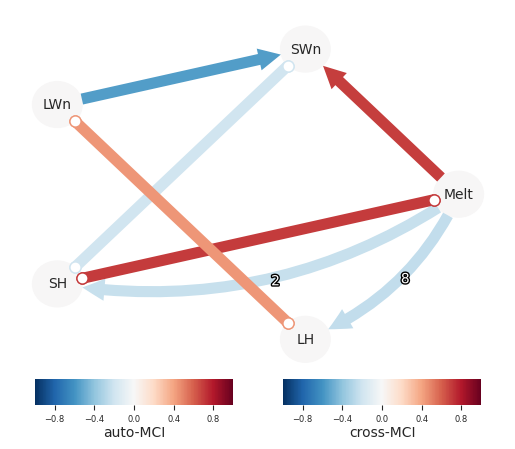

In [28]:
# without pcmci+ false-discovery rate contral
tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    ); #plt.show()

plot_dir = home_dir+'2023-GrIS-melt-causality/plot/RACMO/clean_mask/'
plt.savefig(plot_dir+'graph_pcmciplus_melt_RACMO_SEB_RACMO_noGHF_realJJA_GrIS_ablation_1940_1969_conservative_nofdrc_robustparcorr_taumax12_alpha01_clean.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)

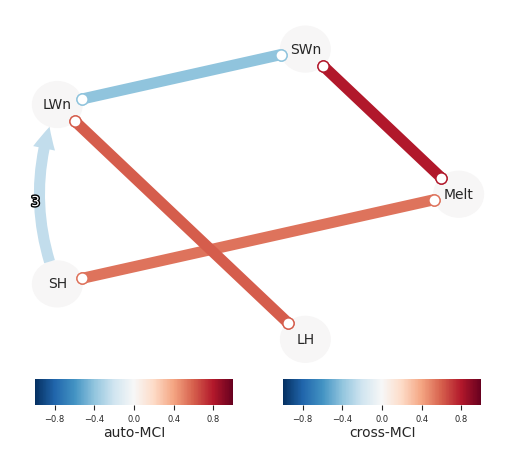

In [29]:
# with pcmci+ false-discovery rate contral
tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    ); #plt.show()

plot_dir = home_dir+'2023-GrIS-melt-causality/plot/RACMO/clean_seasonality_mask/'
plt.savefig(plot_dir+'graph_pcmciplus_melt_RACMO_SEB_RACMO_noGHF_realJJA_GrIS_ablation_seasonality_1940_2014_conservative_fdrc_robustparcorr_clean.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)

cross-MCI: colors show the link coefficients (or edge weight) at the lag with maximum absolute link coefficient (lag label);
auto-MCI: colors depict the link coefficient of the lag-1 autocorrelation links.

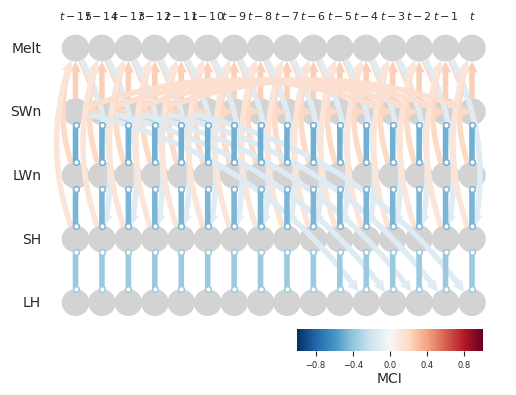

In [42]:
# Plot time series graph    
tp.plot_time_series_graph(
    figsize=(6, 4),
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='MCI',
    ); plt.show()

While the process graph is nicer to look at, the time series graph better represents the spatio-temporal dependency structure from which causal pathways can be read off. You can adjust the size and aspect ratio of nodes with `node_size` and `node_aspect` parameters, and also modify many other properties, see the parameters of `plot_graph` and `plot_time_series_graph`.

Alternatively, the links can also be exported to a ``csv``-file:

## Bootstrap

### tau_max = 12

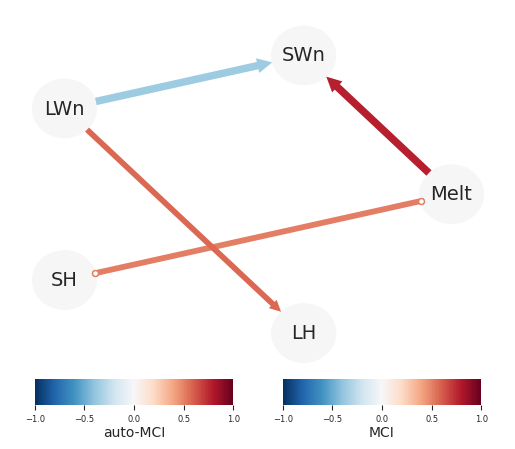

In [28]:
# alpha = 0.01
pc_alpha_bootstrap = 0.01
boot_samples = 100
tau_max = 15

# The block-length of the bootstrap can optionally be used to better deal with autocorrelation, 
# but its effect was not yet evaluated.
boot_blocklength = 1

## Create PCMCI object to call run_bootstrap_of
pcmci = PCMCI(dataframe=dataframe,
        cond_ind_test=robustparcorr,
        verbosity=0,
        )

# Call bootstrap for the chosen method (here 'run_pcmciplus') and pass method arguments  
results = pcmci.run_bootstrap_of(
        method='run_pcmciplus', 
        method_args={'tau_max':tau_max, 'pc_alpha':pc_alpha_bootstrap, 'contemp_collider_rule':'conservative'}, 
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=123)

# Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
boot_linkfreq = results['summary_results']['link_frequency']
boot_graph = results['summary_results']['most_frequent_links']
val_mat = results['summary_results']['val_matrix_mean']

# Plot
tp.plot_graph(
    graph = boot_graph,
    val_matrix= val_mat,
    link_width = boot_linkfreq,
    var_names=dataframe.var_names,
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    );

plot_dir = home_dir+'2023-GrIS-melt-causality/plot/RACMO/clean_seasonality_mask/'
plt.savefig(plot_dir+'graph_pcmciplus_bootstrap_melt_RACMO_SEB_RACMO_noGHF_realJJA_GrIS_ablation_seasonality_1940_2014_conservative_nofdrc_robustparcorr_maxtau15_alpha001_clean.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)

##### without seasonal cycle, max_lag=12, pc_alpha=0.025

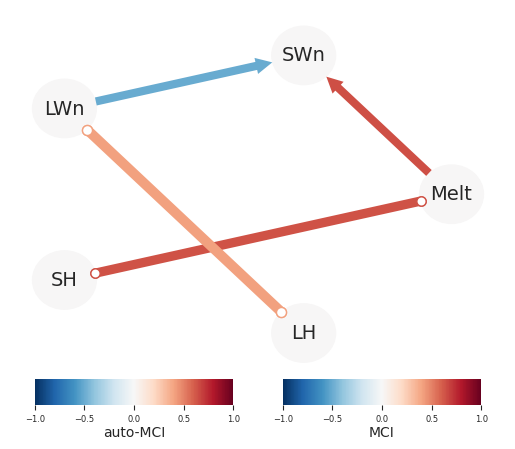

In [62]:
# alpha = 0.025
pc_alpha_bootstrap = 0.025
boot_samples = 100
tau_max = 12

# The block-length of the bootstrap can optionally be used to better deal with autocorrelation, 
# but its effect was not yet evaluated.
boot_blocklength = 1

## Create PCMCI object to call run_bootstrap_of
pcmci = PCMCI(dataframe=dataframe,
        cond_ind_test=robustparcorr,
        verbosity=0,
        )

# Call bootstrap for the chosen method (here 'run_pcmciplus') and pass method arguments  
results = pcmci.run_bootstrap_of(
        method='run_pcmciplus', 
        method_args={'tau_max':tau_max, 'pc_alpha':pc_alpha_bootstrap, 'contemp_collider_rule':'conservative'}, 
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=123)

# Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
boot_linkfreq = results['summary_results']['link_frequency']
boot_graph = results['summary_results']['most_frequent_links']
val_mat = results['summary_results']['val_matrix_mean'] # mean of all graphs?

# Plot
tp.plot_graph(
    graph = boot_graph,
    val_matrix= val_mat,
    link_width = boot_linkfreq,
    var_names=dataframe.var_names,
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    );

plot_dir = home_dir+'2023-GrIS-melt-causality/plot/RACMO/clean_mask/'
plt.savefig(plot_dir+'graph_pcmciplus_bootstrap_melt_RACMO_SEB_RACMO_noGHF_realJJA_GrIS_ablation_seasonality_1940_1969_conservative_nofdrc_robustparcorr_maxtau'+str(tau_max)+'_alpha'+str(pc_alpha_bootstrap)+'_clean.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

In [63]:
#The links can also be exported to a csv file:
tp.write_csv(
    val_matrix=val_mat,
    graph=boot_graph,
    var_names=dataframe.var_names,
    link_width=boot_linkfreq,
    save_name=home_dir+'2023-GrIS-melt-causality/data/RACMO/graph_pcmciplus_bootstrap_melt_RACMO_SEB_RACMO_noGHF_realJJA_GrIS_ablation_seasonality_1940_1969_conservative_nofdrc_robustparcorr_maxtau'+str(tau_max)+'_alpha'+str(pc_alpha_bootstrap)+'_clean.csv',
    digits=5,
)

In [64]:
save_name = home_dir+'2023-GrIS-melt-causality/data/RACMO/graph_pcmciplus_bootstrap_melt_RACMO_SEB_RACMO_noGHF_realJJA_GrIS_ablation_seasonality_1940_1969_conservative_nofdrc_robustparcorr_maxtau'+str(tau_max)+'_alpha'+str(pc_alpha_bootstrap)+'_clean.csv'
pd.read_csv(save_name)

,Variable i,Variable j,Time lag of i,Link type i --- j,Link value,Link width
0,Melt,SWn,0,-->,0.64793,0.58
1,Melt,SH,0,o-o,0.63711,0.67
2,SWn,LWn,0,<--,-0.50387,0.59
3,LWn,LH,0,o-o,0.41353,0.72


In [65]:
# Save for plotting (since the format saved by tp.write_csv is hard to use)
save_name = home_dir+'2023-GrIS-melt-causality/data/RACMO/graph_pcmciplus_bootstrap_melt_RACMO_SEB_RACMO_noGHF_realJJA_GrIS_ablation_seasonality_1940_1969_conservative_nofdrc_robustparcorr_maxtau'+str(tau_max)+'_alpha'+str(pc_alpha_bootstrap)+'_clean_forplot.npz'

np.savez(save_name,
         val_matrix=val_mat,
         graph=boot_graph,
         link_width=boot_linkfreq,
         var_names=dataframe.var_names)

##### without seasonal cycle, max_lag=12, pc_alpha=0.05

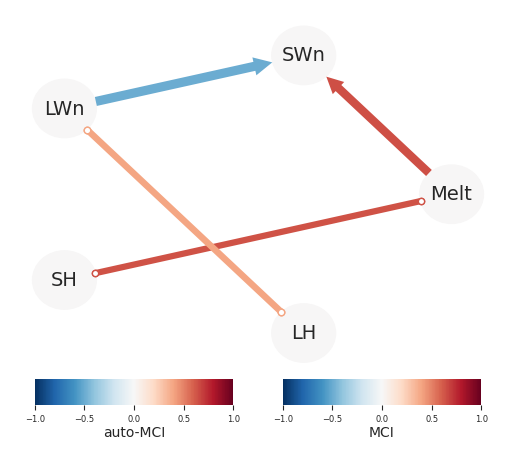

In [37]:
# alpha = 0.05
pc_alpha_bootstrap = 0.05
boot_samples = 100
tau_max = 12

# The block-length of the bootstrap can optionally be used to better deal with autocorrelation, 
# but its effect was not yet evaluated.
boot_blocklength = 1

## Create PCMCI object to call run_bootstrap_of
pcmci = PCMCI(dataframe=dataframe,
        cond_ind_test=robustparcorr,
        verbosity=0,
        )

# Call bootstrap for the chosen method (here 'run_pcmciplus') and pass method arguments  
results = pcmci.run_bootstrap_of(
        method='run_pcmciplus', 
        method_args={'tau_max':tau_max, 'pc_alpha':pc_alpha_bootstrap, 'contemp_collider_rule':'conservative'}, 
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=123)

# Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
boot_linkfreq = results['summary_results']['link_frequency']
boot_graph = results['summary_results']['most_frequent_links']
val_mat = results['summary_results']['val_matrix_mean'] # mean of all graphs?

# Plot
tp.plot_graph(
    graph = boot_graph,
    val_matrix= val_mat,
    link_width = boot_linkfreq,
    var_names=dataframe.var_names,
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    );

plot_dir = home_dir+'2023-GrIS-melt-causality/plot/RACMO/clean_mask/'
plt.savefig(plot_dir+'graph_pcmciplus_bootstrap_melt_RACMO_SEB_RACMO_noGHF_realJJA_GrIS_ablation_seasonality_1940_1969_conservative_nofdrc_robustparcorr_maxtau'+str(tau_max)+'_alpha'+str(pc_alpha_bootstrap)+'_clean.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

In [38]:
#The links can also be exported to a csv file:
tp.write_csv(
    val_matrix=val_mat,
    graph=boot_graph,
    var_names=dataframe.var_names,
    link_width=boot_linkfreq,
    save_name=home_dir+'2023-GrIS-melt-causality/data/RACMO/graph_pcmciplus_bootstrap_melt_RACMO_SEB_RACMO_noGHF_realJJA_GrIS_ablation_seasonality_1940_1969_conservative_nofdrc_robustparcorr_maxtau'+str(tau_max)+'_alpha'+str(pc_alpha_bootstrap)+'_clean.csv',
    digits=5,
)

In [51]:
save_name = home_dir+'2023-GrIS-melt-causality/data/RACMO/graph_pcmciplus_bootstrap_melt_RACMO_SEB_RACMO_noGHF_realJJA_GrIS_ablation_seasonality_1940_1969_conservative_nofdrc_robustparcorr_maxtau'+str(tau_max)+'_alpha'+str(pc_alpha_bootstrap)+'_clean.csv'
pd.read_csv(save_name)

,Variable i,Variable j,Time lag of i,Link type i --- j,Link value,Link width
0,Melt,SWn,0,-->,0.64215,0.60
1,Melt,SH,0,o-o,0.63540,0.45
2,SWn,LWn,0,<--,-0.49564,0.66
3,LWn,LH,0,o-o,0.39458,0.47


In [53]:
# Save for plotting (since the format saved by tp.write_csv is hard to use)
save_name = home_dir+'2023-GrIS-melt-causality/data/RACMO/graph_pcmciplus_bootstrap_melt_RACMO_SEB_RACMO_noGHF_realJJA_GrIS_ablation_seasonality_1940_1969_conservative_nofdrc_robustparcorr_maxtau'+str(tau_max)+'_alpha'+str(pc_alpha_bootstrap)+'_clean_forplot.npz'

np.savez(save_name,
         val_matrix=val_mat,
         graph=boot_graph,
         link_width=boot_linkfreq,
         var_names=dataframe.var_names)

##### without seasonal cycle, max_lag=12, pc_alpha=0.1

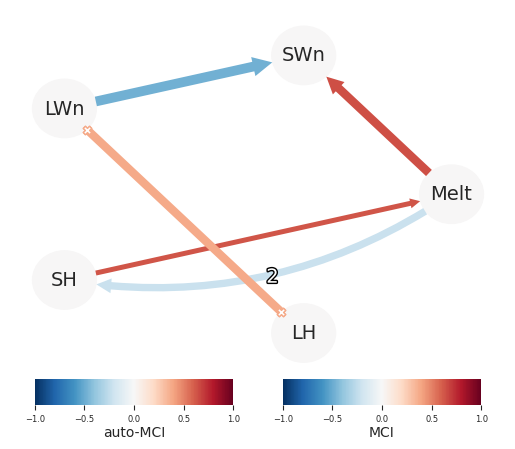

In [54]:
# alpha = 0.1
pc_alpha_bootstrap = 0.1
boot_samples = 100
tau_max = 12

# The block-length of the bootstrap can optionally be used to better deal with autocorrelation, 
# but its effect was not yet evaluated.
boot_blocklength = 1

## Create PCMCI object to call run_bootstrap_of
pcmci = PCMCI(dataframe=dataframe,
        cond_ind_test=robustparcorr,
        verbosity=0,
        )

# Call bootstrap for the chosen method (here 'run_pcmciplus') and pass method arguments  
results = pcmci.run_bootstrap_of(
        method='run_pcmciplus', 
        method_args={'tau_max':tau_max, 'pc_alpha':pc_alpha_bootstrap, 'contemp_collider_rule':'conservative'}, 
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=123)

# Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
boot_linkfreq = results['summary_results']['link_frequency']
boot_graph = results['summary_results']['most_frequent_links']
val_mat = results['summary_results']['val_matrix_mean']

# Plot
tp.plot_graph(
    graph = boot_graph,
    val_matrix= val_mat,
    link_width = boot_linkfreq,
    var_names=dataframe.var_names,
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    );

plot_dir = home_dir+'2023-GrIS-melt-causality/plot/RACMO/clean_mask/'
plt.savefig(plot_dir+'graph_pcmciplus_bootstrap_melt_RACMO_SEB_RACMO_noGHF_realJJA_GrIS_ablation_seasonality_1940_1969_conservative_nofdrc_robustparcorr_maxtau'+str(tau_max)+'_alpha'+str(pc_alpha_bootstrap)+'_clean.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

In [30]:
boot_graph[0,:,:]

array([['', '', '', '', '', '', '', '', '', '', '', '', ''],
       ['-->', '', '', '', '', '', '', '', '', '', '', '', ''],
       ['', '', '', '', '', '', '', '', '', '', '', '', ''],
       ['<--', '', '-->', '', '', '', '', '', '', '', '', '', ''],
       ['', '', '', '', '', '', '', '', '', '', '', '', '']], dtype='<U3')

In [31]:
np.where(boot_graph != '', val_mat, np.NaN)[0,:,:]

array([[        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan],
       [ 0.64472514,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan],
       [ 0.62892719,         nan, -0.22507399,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan]])

In [34]:
results['summary_results']

{'most_frequent_links': array([[['', '', '', '', '', '', '', '', '', '', '', '', ''],
         ['-->', '', '', '', '', '', '', '', '', '', '', '', ''],
         ['', '', '', '', '', '', '', '', '', '', '', '', ''],
         ['<--', '', '-->', '', '', '', '', '', '', '', '', '', ''],
         ['', '', '', '', '', '', '', '', '', '', '', '', '']],
 
        [['<--', '', '', '', '', '', '', '', '', '', '', '', ''],
         ['', '', '', '', '', '', '', '', '', '', '', '', ''],
         ['<--', '', '', '', '', '', '', '', '', '', '', '', ''],
         ['', '', '', '', '', '', '', '', '', '', '', '', ''],
         ['', '', '', '', '', '', '', '', '', '', '', '', '']],
 
        [['', '', '', '', '', '', '', '', '', '', '', '', ''],
         ['-->', '', '', '', '', '', '', '', '', '', '', '', ''],
         ['', '', '', '', '', '', '', '', '', '', '', '', ''],
         ['', '', '', '', '', '', '', '', '', '', '', '', ''],
         ['x-x', '', '', '', '', '', '', '', '', '', '', '', '']],
 
  

In [55]:
#The links can also be exported to a csv file:
tp.write_csv(
    val_matrix=val_mat,
    graph=boot_graph,
    var_names=dataframe.var_names,
    link_width=boot_linkfreq,
    save_name=home_dir+'2023-GrIS-melt-causality/data/RACMO/graph_pcmciplus_bootstrap_melt_RACMO_SEB_RACMO_noGHF_realJJA_GrIS_ablation_seasonality_1940_1969_conservative_nofdrc_robustparcorr_maxtau'+str(tau_max)+'_alpha'+str(pc_alpha_bootstrap)+'_clean.csv',
    digits=5,
)

In [56]:
save_name = home_dir+'2023-GrIS-melt-causality/data/RACMO/graph_pcmciplus_bootstrap_melt_RACMO_SEB_RACMO_noGHF_realJJA_GrIS_ablation_seasonality_1940_1969_conservative_nofdrc_robustparcorr_maxtau'+str(tau_max)+'_alpha'+str(pc_alpha_bootstrap)+'_clean.csv'
pd.read_csv(save_name)

,Variable i,Variable j,Time lag of i,Link type i --- j,Link value,Link width
0,Melt,SWn,0,-->,0.64473,0.61
1,Melt,SH,0,<--,0.62893,0.36
2,Melt,SH,2,-->,-0.22507,0.53
3,SWn,LWn,0,<--,-0.48090,0.70
4,LWn,LH,0,x-x,0.37699,0.60


In [57]:
# Save for plotting (since the format saved by tp.write_csv is hard to use)
save_name = home_dir+'2023-GrIS-melt-causality/data/RACMO/graph_pcmciplus_bootstrap_melt_RACMO_SEB_RACMO_noGHF_realJJA_GrIS_ablation_seasonality_1940_1969_conservative_nofdrc_robustparcorr_maxtau'+str(tau_max)+'_alpha'+str(pc_alpha_bootstrap)+'_clean_forplot.npz'

np.savez(save_name,
         val_matrix=val_mat,
         graph=boot_graph,
         link_width=boot_linkfreq,
         var_names=dataframe.var_names)

##### without seasonal cycle, max_lag=12, pc_alpha=None

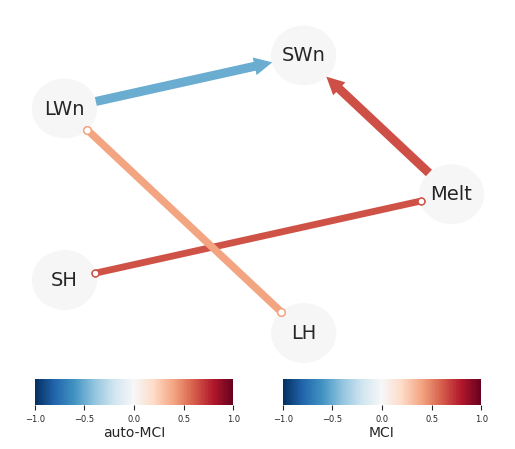

In [58]:
# alpha = None
pc_alpha_bootstrap = None
boot_samples = 100
tau_max = 12

# The block-length of the bootstrap can optionally be used to better deal with autocorrelation, 
# but its effect was not yet evaluated.
boot_blocklength = 1

## Create PCMCI object to call run_bootstrap_of
pcmci = PCMCI(dataframe=dataframe,
        cond_ind_test=robustparcorr,
        verbosity=0,
        )

# Call bootstrap for the chosen method (here 'run_pcmciplus') and pass method arguments  
results = pcmci.run_bootstrap_of(
        method='run_pcmciplus', 
        method_args={'tau_max':tau_max, 'pc_alpha':pc_alpha_bootstrap, 'contemp_collider_rule':'conservative'}, 
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=123)

# Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
boot_linkfreq = results['summary_results']['link_frequency']
boot_graph = results['summary_results']['most_frequent_links']
val_mat = results['summary_results']['val_matrix_mean']

# Plot
tp.plot_graph(
    graph = boot_graph,
    val_matrix= val_mat,
    link_width = boot_linkfreq,
    var_names=dataframe.var_names,
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    );

plot_dir = home_dir+'2023-GrIS-melt-causality/plot/RACMO/clean_mask/'
plt.savefig(plot_dir+'graph_pcmciplus_bootstrap_melt_RACMO_SEB_RACMO_noGHF_realJJA_GrIS_ablation_seasonality_1940_1969_conservative_nofdrc_robustparcorr_maxtau'+str(tau_max)+'_alpha'+str(pc_alpha_bootstrap)+'_clean.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

In [59]:
#The links can also be exported to a csv file:
tp.write_csv(
    val_matrix=val_mat,
    graph=boot_graph,
    var_names=dataframe.var_names,
    link_width=boot_linkfreq,
    save_name=home_dir+'2023-GrIS-melt-causality/data/RACMO/graph_pcmciplus_bootstrap_melt_RACMO_SEB_RACMO_noGHF_realJJA_GrIS_ablation_seasonality_1940_1969_conservative_nofdrc_robustparcorr_maxtau'+str(tau_max)+'_alpha'+str(pc_alpha_bootstrap)+'_clean.csv',
    digits=5,
)

In [60]:
save_name = home_dir+'2023-GrIS-melt-causality/data/RACMO/graph_pcmciplus_bootstrap_melt_RACMO_SEB_RACMO_noGHF_realJJA_GrIS_ablation_seasonality_1940_1969_conservative_nofdrc_robustparcorr_maxtau'+str(tau_max)+'_alpha'+str(pc_alpha_bootstrap)+'_clean.csv'
pd.read_csv(save_name)

,Variable i,Variable j,Time lag of i,Link type i --- j,Link value,Link width
0,Melt,SWn,0,-->,0.64731,0.64
1,Melt,SH,0,o-o,0.63589,0.49
2,SWn,LWn,0,<--,-0.49917,0.65
3,LWn,LH,0,o-o,0.40130,0.54


In [61]:
# Save for plotting (since the format saved by tp.write_csv is hard to use)
save_name = home_dir+'2023-GrIS-melt-causality/data/RACMO/graph_pcmciplus_bootstrap_melt_RACMO_SEB_RACMO_noGHF_realJJA_GrIS_ablation_seasonality_1940_1969_conservative_nofdrc_robustparcorr_maxtau'+str(tau_max)+'_alpha'+str(pc_alpha_bootstrap)+'_clean_forplot.npz'

np.savez(save_name,
         val_matrix=val_mat,
         graph=boot_graph,
         link_width=boot_linkfreq,
         var_names=dataframe.var_names)

### tau_max = 6

##### without seasonal cycle, max_lag=6, pc_alpha=0.1

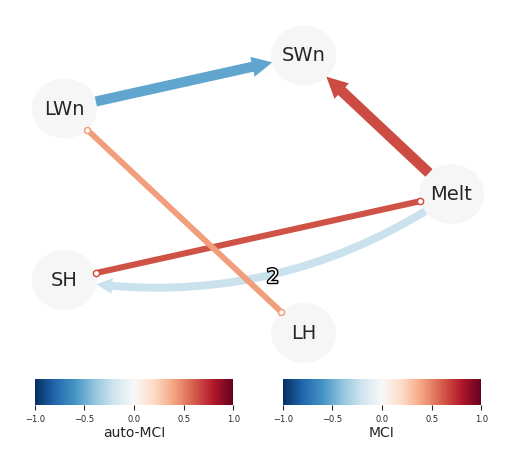

In [28]:
# alpha = 0.1
pc_alpha_bootstrap = 0.1
boot_samples = 100
tau_max = 6

# The block-length of the bootstrap can optionally be used to better deal with autocorrelation, 
# but its effect was not yet evaluated.
boot_blocklength = 1

## Create PCMCI object to call run_bootstrap_of
pcmci = PCMCI(dataframe=dataframe,
        cond_ind_test=robustparcorr,
        verbosity=0,
        )

# Call bootstrap for the chosen method (here 'run_pcmciplus') and pass method arguments  
results = pcmci.run_bootstrap_of(
        method='run_pcmciplus', 
        method_args={'tau_max':tau_max, 'pc_alpha':pc_alpha_bootstrap, 'contemp_collider_rule':'conservative'}, 
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=123)

# Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
boot_linkfreq = results['summary_results']['link_frequency']
boot_graph = results['summary_results']['most_frequent_links']
val_mat = results['summary_results']['val_matrix_mean']

# Plot
tp.plot_graph(
    graph = boot_graph,
    val_matrix= val_mat,
    link_width = boot_linkfreq,
    var_names=dataframe.var_names,
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    );

plot_dir = home_dir+'2023-GrIS-melt-causality/plot/RACMO/clean_mask/'
plt.savefig(plot_dir+'graph_pcmciplus_bootstrap_melt_RACMO_SEB_RACMO_noGHF_realJJA_GrIS_ablation_seasonality_1940_1969_conservative_nofdrc_robustparcorr_maxtau'+str(tau_max)+'_alpha'+str(pc_alpha_bootstrap)+'_clean.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

### tau_max = 18

##### without seasonal cycle, max_lag=18, pc_alpha=0.1

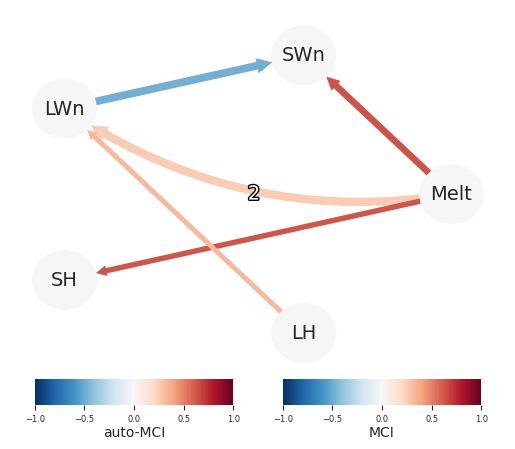

In [29]:
# alpha = 0.1
pc_alpha_bootstrap = 0.1
boot_samples = 100
tau_max = 18

# The block-length of the bootstrap can optionally be used to better deal with autocorrelation, 
# but its effect was not yet evaluated.
boot_blocklength = 1

## Create PCMCI object to call run_bootstrap_of
pcmci = PCMCI(dataframe=dataframe,
        cond_ind_test=robustparcorr,
        verbosity=0,
        )

# Call bootstrap for the chosen method (here 'run_pcmciplus') and pass method arguments  
results = pcmci.run_bootstrap_of(
        method='run_pcmciplus', 
        method_args={'tau_max':tau_max, 'pc_alpha':pc_alpha_bootstrap, 'contemp_collider_rule':'conservative'}, 
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=123)

# Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
boot_linkfreq = results['summary_results']['link_frequency']
boot_graph = results['summary_results']['most_frequent_links']
val_mat = results['summary_results']['val_matrix_mean']

# Plot
tp.plot_graph(
    graph = boot_graph,
    val_matrix= val_mat,
    link_width = boot_linkfreq,
    var_names=dataframe.var_names,
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    );

plot_dir = home_dir+'2023-GrIS-melt-causality/plot/RACMO/clean_mask/'
plt.savefig(plot_dir+'graph_pcmciplus_bootstrap_melt_RACMO_SEB_RACMO_noGHF_realJJA_GrIS_ablation_seasonality_1940_1969_conservative_nofdrc_robustparcorr_maxtau'+str(tau_max)+'_alpha'+str(pc_alpha_bootstrap)+'_clean.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

In [55]:
#The links can also be exported to a csv file:
tp.write_csv(
    val_matrix=val_mat,
    graph=boot_graph,
    var_names=dataframe.var_names,
    link_width=boot_linkfreq,
    save_name=home_dir+'2023-GrIS-melt-causality/data/RACMO/graph_pcmciplus_bootstrap_melt_RACMO_SEB_RACMO_noGHF_realJJA_GrIS_ablation_seasonality_1940_1969_conservative_nofdrc_robustparcorr_maxtau'+str(tau_max)+'_alpha'+str(pc_alpha_bootstrap)+'_clean.csv',
    digits=5,
)

In [56]:
save_name = home_dir+'2023-GrIS-melt-causality/data/RACMO/graph_pcmciplus_bootstrap_melt_RACMO_SEB_RACMO_noGHF_realJJA_GrIS_ablation_seasonality_1940_1969_conservative_nofdrc_robustparcorr_maxtau'+str(tau_max)+'_alpha'+str(pc_alpha_bootstrap)+'_clean.csv'
pd.read_csv(save_name)

,Variable i,Variable j,Time lag of i,Link type i --- j,Link value,Link width
0,Melt,SWn,0,-->,0.64473,0.61
1,Melt,SH,0,<--,0.62893,0.36
2,Melt,SH,2,-->,-0.22507,0.53
3,SWn,LWn,0,<--,-0.48090,0.70
4,LWn,LH,0,x-x,0.37699,0.60


In [57]:
# Save for plotting (since the format saved by tp.write_csv is hard to use)
save_name = home_dir+'2023-GrIS-melt-causality/data/RACMO/graph_pcmciplus_bootstrap_melt_RACMO_SEB_RACMO_noGHF_realJJA_GrIS_ablation_seasonality_1940_1969_conservative_nofdrc_robustparcorr_maxtau'+str(tau_max)+'_alpha'+str(pc_alpha_bootstrap)+'_clean_forplot.npz'

np.savez(save_name,
         val_matrix=val_mat,
         graph=boot_graph,
         link_width=boot_linkfreq,
         var_names=dataframe.var_names)

### tau_max = 5

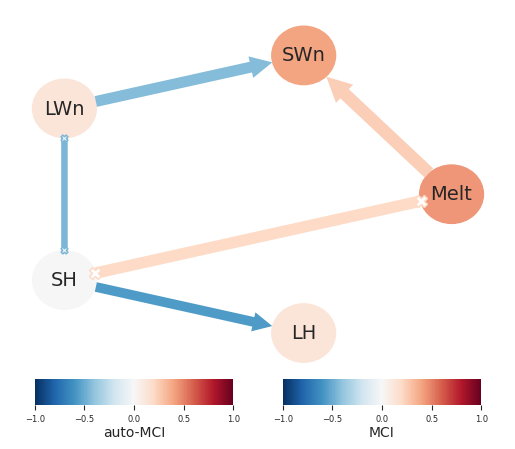

In [43]:
# alpha = 0.01
pc_alpha_bootstrap = 0.01
boot_samples = 100
tau_max = 5

# The block-length of the bootstrap can optionally be used to better deal with autocorrelation, 
# but its effect was not yet evaluated.
boot_blocklength = 1

## Create PCMCI object to call run_bootstrap_of
pcmci = PCMCI(dataframe=dataframe,
        cond_ind_test=parcorr,
        verbosity=0,
        )

# Call bootstrap for the chosen method (here 'run_pcmciplus') and pass method arguments  
results = pcmci.run_bootstrap_of(
        method='run_pcmciplus', 
        method_args={'tau_max':tau_max, 'pc_alpha':pc_alpha_bootstrap, 'contemp_collider_rule':'conservative'}, 
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=123)

# Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
boot_linkfreq = results['summary_results']['link_frequency']
boot_graph = results['summary_results']['most_frequent_links']
val_mat = results['summary_results']['val_matrix_mean']

# Plot
tp.plot_graph(
    graph = boot_graph,
    val_matrix= val_mat,
    link_width = boot_linkfreq,
    var_names=dataframe.var_names,
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    );

plt.savefig(home_dir+'GrIS_melt_causality/plot/RACMO_ERA5/graph_pcmciplus_bootstrap_melt_RACMO_SEB_ERA5_noGHF_JJA_GrIS_ablation_1958_2022_conservative_nofdrc_alpha001_taumax5.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)

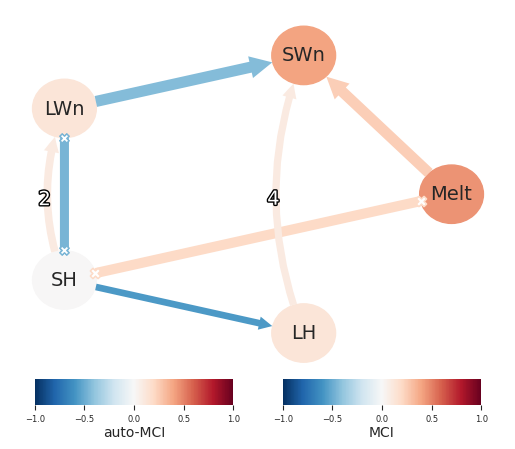

In [44]:
# alpha = 0.025
pc_alpha_bootstrap = 0.025
boot_samples = 100
tau_max = 5

# The block-length of the bootstrap can optionally be used to better deal with autocorrelation, 
# but its effect was not yet evaluated.
boot_blocklength = 1

## Create PCMCI object to call run_bootstrap_of
pcmci = PCMCI(dataframe=dataframe,
        cond_ind_test=parcorr,
        verbosity=0,
        )

# Call bootstrap for the chosen method (here 'run_pcmciplus') and pass method arguments  
results = pcmci.run_bootstrap_of(
        method='run_pcmciplus', 
        method_args={'tau_max':tau_max, 'pc_alpha':pc_alpha_bootstrap, 'contemp_collider_rule':'conservative'}, 
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=123)

# Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
boot_linkfreq = results['summary_results']['link_frequency']
boot_graph = results['summary_results']['most_frequent_links']
val_mat = results['summary_results']['val_matrix_mean']

# Plot
tp.plot_graph(
    graph = boot_graph,
    val_matrix= val_mat,
    link_width = boot_linkfreq,
    var_names=dataframe.var_names,
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    );

plt.savefig(home_dir+'GrIS_melt_causality/plot/RACMO_ERA5/graph_pcmciplus_bootstrap_melt_RACMO_SEB_ERA5_noGHF_JJA_GrIS_ablation_1958_2022_conservative_nofdrc_alpha0025_taumax5.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)

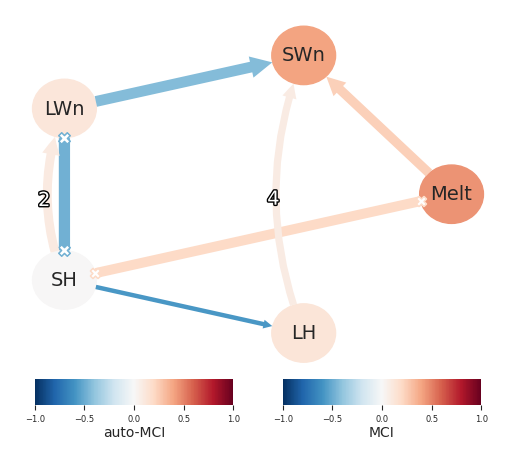

In [45]:
# alpha = 0.05
pc_alpha_bootstrap = 0.05
boot_samples = 100
tau_max = 5

# The block-length of the bootstrap can optionally be used to better deal with autocorrelation, 
# but its effect was not yet evaluated.
boot_blocklength = 1

## Create PCMCI object to call run_bootstrap_of
pcmci = PCMCI(dataframe=dataframe,
        cond_ind_test=parcorr,
        verbosity=0,
        )

# Call bootstrap for the chosen method (here 'run_pcmciplus') and pass method arguments  
results = pcmci.run_bootstrap_of(
        method='run_pcmciplus', 
        method_args={'tau_max':tau_max, 'pc_alpha':pc_alpha_bootstrap, 'contemp_collider_rule':'conservative'}, 
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=123)

# Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
boot_linkfreq = results['summary_results']['link_frequency']
boot_graph = results['summary_results']['most_frequent_links']
val_mat = results['summary_results']['val_matrix_mean']

# Plot
tp.plot_graph(
    graph = boot_graph,
    val_matrix= val_mat,
    link_width = boot_linkfreq,
    var_names=dataframe.var_names,
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    );

plt.savefig(home_dir+'GrIS_melt_causality/plot/RACMO_ERA5/graph_pcmciplus_bootstrap_melt_RACMO_SEB_ERA5_noGHF_JJA_GrIS_ablation_1958_2022_conservative_nofdrc_alpha005_taumax5.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)

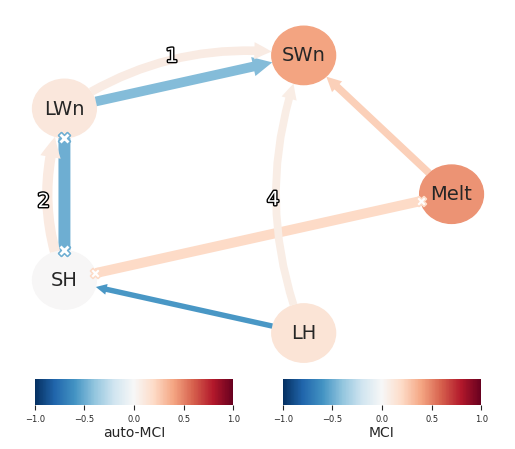

In [46]:
# alpha = 0.1
pc_alpha_bootstrap = 0.1
boot_samples = 100
tau_max = 5

# The block-length of the bootstrap can optionally be used to better deal with autocorrelation, 
# but its effect was not yet evaluated.
boot_blocklength = 1

## Create PCMCI object to call run_bootstrap_of
pcmci = PCMCI(dataframe=dataframe,
        cond_ind_test=parcorr,
        verbosity=0,
        )

# Call bootstrap for the chosen method (here 'run_pcmciplus') and pass method arguments  
results = pcmci.run_bootstrap_of(
        method='run_pcmciplus', 
        method_args={'tau_max':tau_max, 'pc_alpha':pc_alpha_bootstrap, 'contemp_collider_rule':'conservative'}, 
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=123)

# Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
boot_linkfreq = results['summary_results']['link_frequency']
boot_graph = results['summary_results']['most_frequent_links']
val_mat = results['summary_results']['val_matrix_mean']

# Plot
tp.plot_graph(
    graph = boot_graph,
    val_matrix= val_mat,
    link_width = boot_linkfreq,
    var_names=dataframe.var_names,
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    );

plt.savefig(home_dir+'GrIS_melt_causality/plot/RACMO_ERA5/graph_pcmciplus_bootstrap_melt_RACMO_SEB_ERA5_noGHF_JJA_GrIS_ablation_1958_2022_conservative_nofdrc_alpha01_taumax5.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)

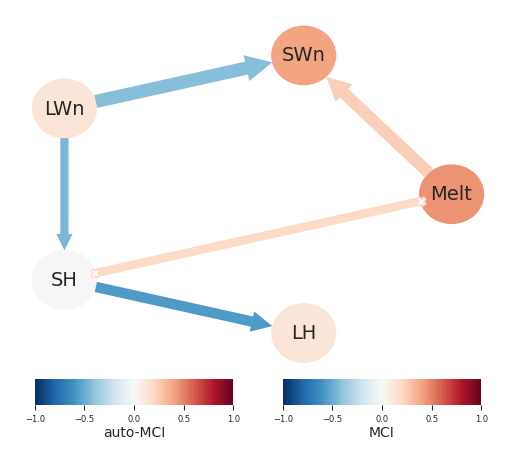

In [47]:
# alpha = None
pc_alpha_bootstrap = None
boot_samples = 100
tau_max = 5

# The block-length of the bootstrap can optionally be used to better deal with autocorrelation, 
# but its effect was not yet evaluated.
boot_blocklength = 1

## Create PCMCI object to call run_bootstrap_of
pcmci = PCMCI(dataframe=dataframe,
        cond_ind_test=parcorr,
        verbosity=0,
        )

# Call bootstrap for the chosen method (here 'run_pcmciplus') and pass method arguments  
results = pcmci.run_bootstrap_of(
        method='run_pcmciplus', 
        method_args={'tau_max':tau_max, 'pc_alpha':pc_alpha_bootstrap, 'contemp_collider_rule':'conservative'}, 
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=123)

# Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
boot_linkfreq = results['summary_results']['link_frequency']
boot_graph = results['summary_results']['most_frequent_links']
val_mat = results['summary_results']['val_matrix_mean']

# Plot
tp.plot_graph(
    graph = boot_graph,
    val_matrix= val_mat,
    link_width = boot_linkfreq,
    var_names=dataframe.var_names,
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    );

plt.savefig(home_dir+'GrIS_melt_causality/plot/RACMO_ERA5/graph_pcmciplus_bootstrap_melt_RACMO_SEB_ERA5_noGHF_JJA_GrIS_ablation_1958_2022_conservative_nofdrc_alphaNone_taumax5.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)

### cond_ind_test=robustparcorr, tau_max = 15

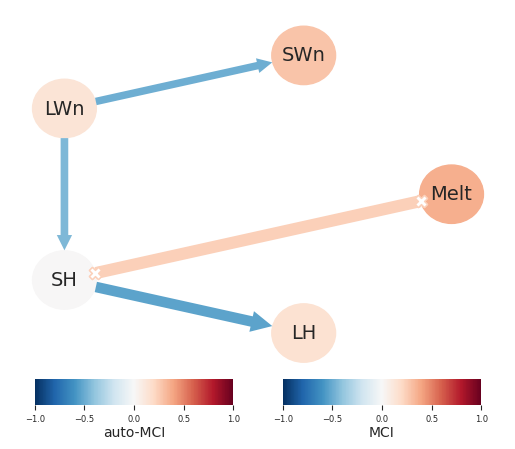

In [52]:
# alpha = 0.01
pc_alpha_bootstrap = 0.01
boot_samples = 100
tau_max = 15

# The block-length of the bootstrap can optionally be used to better deal with autocorrelation, 
# but its effect was not yet evaluated.
boot_blocklength = 1

## Create PCMCI object to call run_bootstrap_of
robustparcorr = RobustParCorr(significance='analytic')
pcmci = PCMCI(dataframe=dataframe,
        cond_ind_test=robustparcorr,
        verbosity=0,
        )

# Call bootstrap for the chosen method (here 'run_pcmciplus') and pass method arguments  
results = pcmci.run_bootstrap_of(
        method='run_pcmciplus', 
        method_args={'tau_max':tau_max, 'pc_alpha':pc_alpha_bootstrap, 'contemp_collider_rule':'conservative'}, 
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=123)

# Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
boot_linkfreq = results['summary_results']['link_frequency']
boot_graph = results['summary_results']['most_frequent_links']
val_mat = results['summary_results']['val_matrix_mean']

# Plot
tp.plot_graph(
    graph = boot_graph,
    val_matrix= val_mat,
    link_width = boot_linkfreq,
    var_names=dataframe.var_names,
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    );

plt.savefig(home_dir+'GrIS_melt_causality/plot/RACMO_ERA5/graph_pcmciplus_bootstrap_melt_RACMO_SEB_ERA5_noGHF_JJA_GrIS_ablation_1958_2022_robustparcorr_conservative_nofdrc_alpha001_taumax15.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)

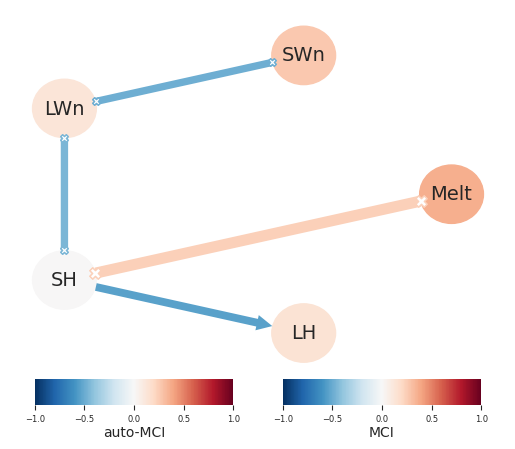

In [53]:
# alpha = 0.025
pc_alpha_bootstrap = 0.025
boot_samples = 100
tau_max = 15

# The block-length of the bootstrap can optionally be used to better deal with autocorrelation, 
# but its effect was not yet evaluated.
boot_blocklength = 1

## Create PCMCI object to call run_bootstrap_of
robustparcorr = RobustParCorr(significance='analytic')
pcmci = PCMCI(dataframe=dataframe,
        cond_ind_test=robustparcorr,
        verbosity=0,
        )

# Call bootstrap for the chosen method (here 'run_pcmciplus') and pass method arguments  
results = pcmci.run_bootstrap_of(
        method='run_pcmciplus', 
        method_args={'tau_max':tau_max, 'pc_alpha':pc_alpha_bootstrap, 'contemp_collider_rule':'conservative'}, 
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=123)

# Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
boot_linkfreq = results['summary_results']['link_frequency']
boot_graph = results['summary_results']['most_frequent_links']
val_mat = results['summary_results']['val_matrix_mean']

# Plot
tp.plot_graph(
    graph = boot_graph,
    val_matrix= val_mat,
    link_width = boot_linkfreq,
    var_names=dataframe.var_names,
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    );

plt.savefig(home_dir+'GrIS_melt_causality/plot/RACMO_ERA5/graph_pcmciplus_bootstrap_melt_RACMO_SEB_ERA5_noGHF_JJA_GrIS_ablation_1958_2022_robustparcorr_conservative_nofdrc_alpha0025_taumax15.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)

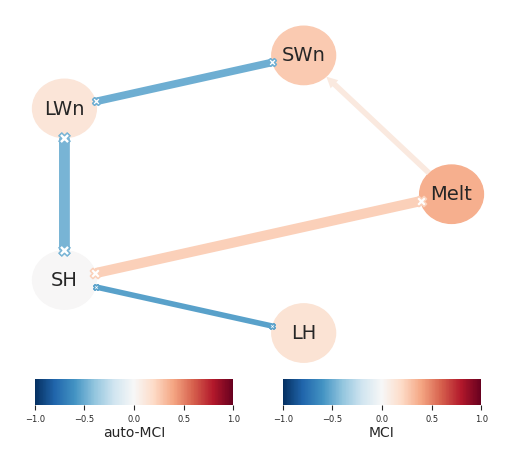

In [54]:
# alpha = 0.05
pc_alpha_bootstrap = 0.05
boot_samples = 100
tau_max = 15

# The block-length of the bootstrap can optionally be used to better deal with autocorrelation, 
# but its effect was not yet evaluated.
boot_blocklength = 1

## Create PCMCI object to call run_bootstrap_of
robustparcorr = RobustParCorr(significance='analytic')
pcmci = PCMCI(dataframe=dataframe,
        cond_ind_test=robustparcorr,
        verbosity=0,
        )

# Call bootstrap for the chosen method (here 'run_pcmciplus') and pass method arguments  
results = pcmci.run_bootstrap_of(
        method='run_pcmciplus', 
        method_args={'tau_max':tau_max, 'pc_alpha':pc_alpha_bootstrap, 'contemp_collider_rule':'conservative'}, 
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=123)

# Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
boot_linkfreq = results['summary_results']['link_frequency']
boot_graph = results['summary_results']['most_frequent_links']
val_mat = results['summary_results']['val_matrix_mean']

# Plot
tp.plot_graph(
    graph = boot_graph,
    val_matrix= val_mat,
    link_width = boot_linkfreq,
    var_names=dataframe.var_names,
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    );

plt.savefig(home_dir+'GrIS_melt_causality/plot/RACMO_ERA5/graph_pcmciplus_bootstrap_melt_RACMO_SEB_ERA5_noGHF_JJA_GrIS_ablation_1958_2022_robustparcorr_conservative_nofdrc_alpha005_taumax15.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)

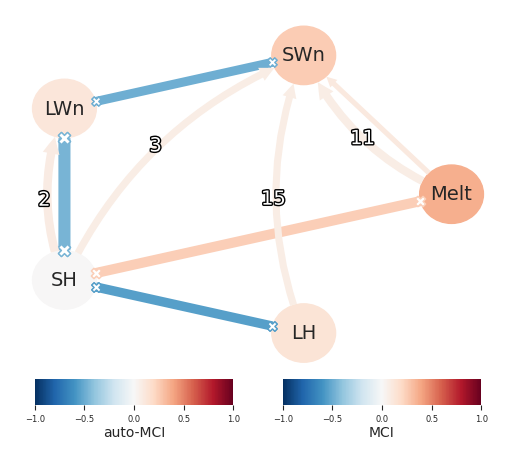

In [55]:
# alpha = 0.1
pc_alpha_bootstrap = 0.1
boot_samples = 100
tau_max = 15

# The block-length of the bootstrap can optionally be used to better deal with autocorrelation, 
# but its effect was not yet evaluated.
boot_blocklength = 1

## Create PCMCI object to call run_bootstrap_of
robustparcorr = RobustParCorr(significance='analytic')
pcmci = PCMCI(dataframe=dataframe,
        cond_ind_test=robustparcorr,
        verbosity=0,
        )

# Call bootstrap for the chosen method (here 'run_pcmciplus') and pass method arguments  
results = pcmci.run_bootstrap_of(
        method='run_pcmciplus', 
        method_args={'tau_max':tau_max, 'pc_alpha':pc_alpha_bootstrap, 'contemp_collider_rule':'conservative'}, 
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=123)

# Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
boot_linkfreq = results['summary_results']['link_frequency']
boot_graph = results['summary_results']['most_frequent_links']
val_mat = results['summary_results']['val_matrix_mean']

# Plot
tp.plot_graph(
    graph = boot_graph,
    val_matrix= val_mat,
    link_width = boot_linkfreq,
    var_names=dataframe.var_names,
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    );

plt.savefig(home_dir+'GrIS_melt_causality/plot/RACMO_ERA5/graph_pcmciplus_bootstrap_melt_RACMO_SEB_ERA5_noGHF_JJA_GrIS_ablation_1958_2022_robustparcorr_conservative_nofdrc_alpha01_taumax15.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)

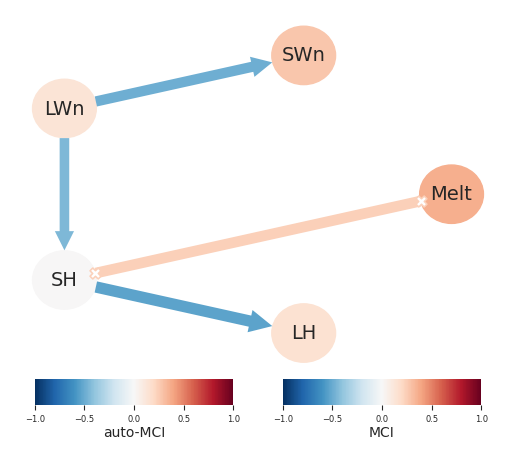

In [56]:
# alpha = None
pc_alpha_bootstrap = None
boot_samples = 100
tau_max = 15

# The block-length of the bootstrap can optionally be used to better deal with autocorrelation, 
# but its effect was not yet evaluated.
boot_blocklength = 1

## Create PCMCI object to call run_bootstrap_of
robustparcorr = RobustParCorr(significance='analytic')
pcmci = PCMCI(dataframe=dataframe,
        cond_ind_test=robustparcorr,
        verbosity=0,
        )

# Call bootstrap for the chosen method (here 'run_pcmciplus') and pass method arguments  
results = pcmci.run_bootstrap_of(
        method='run_pcmciplus', 
        method_args={'tau_max':tau_max, 'pc_alpha':pc_alpha_bootstrap, 'contemp_collider_rule':'conservative'}, 
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=123)

# Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
boot_linkfreq = results['summary_results']['link_frequency']
boot_graph = results['summary_results']['most_frequent_links']
val_mat = results['summary_results']['val_matrix_mean']

# Plot
tp.plot_graph(
    graph = boot_graph,
    val_matrix= val_mat,
    link_width = boot_linkfreq,
    var_names=dataframe.var_names,
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    );

plt.savefig(home_dir+'GrIS_melt_causality/plot/RACMO_ERA5/graph_pcmciplus_bootstrap_melt_RACMO_SEB_ERA5_noGHF_JJA_GrIS_ablation_1958_2022_robustparcorr_conservative_nofdrc_alphaNone_taumax15.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)

### cond_ind_test=gpdc, tau_max = 15

Couldn't finish with bootstrap

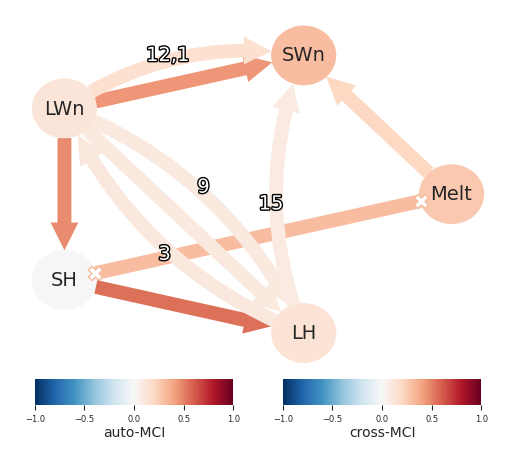

In [66]:
## alpha = 0.05

# Create PCMCI object
gpdc = GPDC(significance='analytic', gp_params=None)
pcmci = PCMCI(dataframe=dataframe,
        cond_ind_test=gpdc,
        verbosity=0,
        )

# Run pcmciplus
results = pcmci.run_pcmciplus(tau_min=0, tau_max=15, pc_alpha=0.05, contemp_collider_rule='conservative') #reset_lagged_links=True adds more links to piControl case, not 4xext

# Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    );

plt.savefig(home_dir+'GrIS_melt_causality/plot/RACMO_ERA5/graph_pcmciplus_melt_RACMO_SEB_ERA5_noGHF_JJA_GrIS_ablation_1958_2022_gpdc_conservative_nofdrc.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)